In [55]:
%run '/mnt/berger2/equipes/IGE/meom/workdir/berger2/fonctions/meom_fonctions/fonctions.ipynb'

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.netcdf as netcdf
import qgutils as qg
from matplotlib import ticker, cm
plt.ion()

In [2]:
#paramètres gravés dans le marbre pour le stage

Delta = 10000                               #grid spacing
f0 = 9.37456E-05                           #paramètre de Coriolis
dh = np.array([350,750,2900])              #hauteurs des couches océaniques
dh_b = np.array([(dh[0]+dh[1])/2,(dh[0]+dh[1])/2])
g_prime = np.array([2.5E-02,1.25E-02])     #gravités réduites aux interfaces
Beta = 1.75360E-11
delta_ek = 5                               #ocean bottom Ekman thickness 
nu4 = 2E09                                 #bi-harmonic viscosity
Ht = np.sum(dh)
Ht_b = np.sum(dh_b)
toc = np.array([1.31693E+01,1.81693E+01,2.41693E+01])
bf = delta_ek*f0/(2*dh[-1])

#fréquences Brunt-vaisala

N_12 = g_prime[0]/((dh[0]+dh[1])/2)
N_23 = g_prime[1]/((dh[1]+dh[2])/2)
N2 = np.array([N_12,N_23])

#densité

rho1= 1000
rho2= 1000*(1-g_prime[0]/9.81)
rho3= rho2 - 1000*g_prime[1]/9.81

rho = np.array([rho1,rho2,rho3])

In [3]:
dir0  = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_7_dt10/'
dir1 = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_6tdiff_dt10/'
file0 = 'ocpo.nc'
file1 = 'ocsst.nc'
file_me = 'avges.nc'
file_at = 'atpa.nc'

In [4]:
#get fields psi
pfile_abs = dir0 + file0
pfile_rel = dir1 + file0

at_file_abs = dir0 + file_at
at_file_rel = dir1 + file_at

avges_abs = dir0 + file_me
avges_rel = dir1 + file_me

file_wek_abs = dir0 + file1
file_wek_rel = dir1 + file1


f_abs = netcdf.netcdf_file(dir0 + file0,'r')
f_rel = netcdf.netcdf_file(dir0 + file1,'r')
f_avges_abs = netcdf.netcdf_file(avges_abs,'r')
f_avges_rel = netcdf.netcdf_file(avges_rel,'r')


In [6]:
flot_me_et = np.load('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/meom_test/Lorenz_cycle/tableaux_termes_abs/etapes_flot_moyen_abs.npz')
#b_me= integral_z(flot_me_et['b_me'], dh_b, Delta, Ht_b)
b_me= flot_me_et['b_me']
p_me = flot_me_et['p_me']

flot_me = np.load('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/meom_test/Lorenz_cycle/tableaux_termes_abs/termes_flot_moyen_abs.npz')
e_diab = flot_me['e_diab']


flot_me_et_rel = np.load('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/meom_test/Lorenz_cycle/tableaux_termes_rel/etapes_flot_moyen_rel.npz')
p_me_rel = flot_me_et_rel['p_me']
b_me_rel = flot_me_et_rel['b_me']

flot_me_rel = np.load('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/meom_test/Lorenz_cycle/tableaux_termes_rel/termes_flot_moyen_rel.npz')
u_me_rel = flot_me_rel['u_me']

In [7]:
#get xp, yp : basin size
xp = f_abs.variables['xp'][:-1].copy()
yp = f_abs.variables['xp'][:-1].copy()
zp = f_abs.variables['z'][:].copy()

In [29]:
#get all abs
w_ek_me_abs = f_avges_abs.variables['wekto'][:,:].copy()
w_ek_abs = qg.read_qgcm(file_wek_abs, 0, var='wekt', rescale = 1, interp = False, subtract_bc = False )


sst_me_abs = f_avges_abs.variables['sst'][:,:].copy()
sst_abs = qg.read_qgcm(file_wek_abs, 0, var='sst', rescale = 1, interp = False, subtract_bc = False)

p_abs_me = qg.interp_on_c(f_avges_abs.variables['po'][:,:,:].copy()/f0)
p_abs = qg.read_qgcm(pfile_abs, 0, var='p', rescale = 1/f0, interp = True, subtract_bc = False)

b_abs_me = qg.p2b(p_abs_me, dh, f0)

In [30]:
#get all rel
w_ek_me_rel = f_avges_rel.variables['wekto'][:,:].copy()
w_ek_rel = qg.read_qgcm(file_wek_rel, 0, var='wekt', rescale = 1, interp = False, subtract_bc = False )


sst_me_rel = f_avges_rel.variables['sst'][:,:].copy()
sst_rel = qg.read_qgcm(file_wek_rel, 0, var='sst', rescale = 1, interp = False, subtract_bc = False )

p_rel_me = qg.interp_on_c(f_avges_rel.variables['po'][:,:,:].copy()/f0)
p_rel = qg.read_qgcm(pfile_rel, 0, var='p', rescale = 1/f0, interp = True, subtract_bc = False)

b_rel_me = qg.p2b(p_rel_me, dh, f0)

In [12]:
N2,f0 = qg.reshape3d(dh,N2,f0)

si_t = f_abs.variables['time'][:].copy().size
nl,N,naux = p_abs.shape

p_at_abs = qg.read_qgcm(at_file_abs, 0, var='p', rescale = 1/f0, interp = True, subtract_bc = False )
nl_at,N_at,naux_at = p_at_abs.shape

test = si_t

average = True

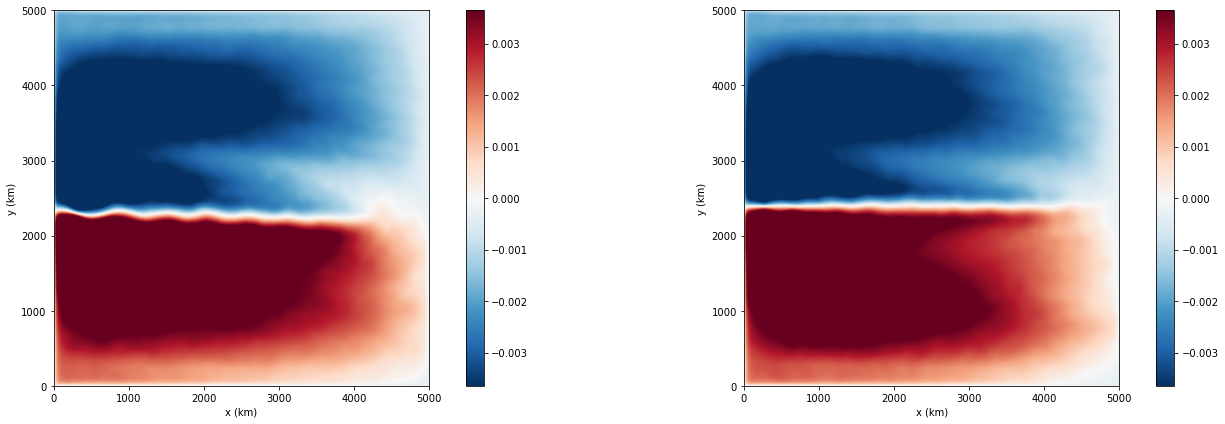

In [54]:
#sst

b_abs_me_i = integral_z(b_abs_me,dh_b,Delta,Ht_b)
b_rel_me_i = integral_z(b_rel_me,dh_b,Delta,Ht_b)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,6),tight_layout=True)

maxi = max(np.max(b_abs_me_i),np.abs(np.min(b_abs_me_i)))

col = ax1.imshow( b_abs_me_i, cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi/2, vmin = -maxi/2)
ax1.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(b_abs_me_i)
m.set_clim(-maxi/2, maxi/2)
plt.colorbar(m, ax= ax1 )#.set_label(r'$m^2.s^{-3}$')

col = ax2.imshow( b_rel_me_i, cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi/2, vmin = -maxi/2)
ax2.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(b_rel_me_i)
m.set_clim(-maxi/2, maxi/2)
plt.colorbar(m, ax= ax2 )#.set_label(r'$m^2.s^{-3}$')



In [31]:
forcing_z_abs = w_ek_me_abs*f0/dh[0]
forcing_b_abs = f_avges_abs.variables['fnetoc'][:,:].copy()

w_abs_me = qg.get_w(p_abs_me,dh,N2,f0,Delta,bf, forcing_z_abs, forcing_b_abs, nu=0, nu4=nu4)

In [33]:
forcing_z_rel = w_ek_me_rel*f0/dh[0]
forcing_b_rel = f_avges_rel.variables['fnetoc'][:,:].copy()

w_rel_me = qg.get_w(p_rel_me,dh,N2,f0,Delta,bf, forcing_z_rel, forcing_b_rel, nu=0, nu4=nu4)

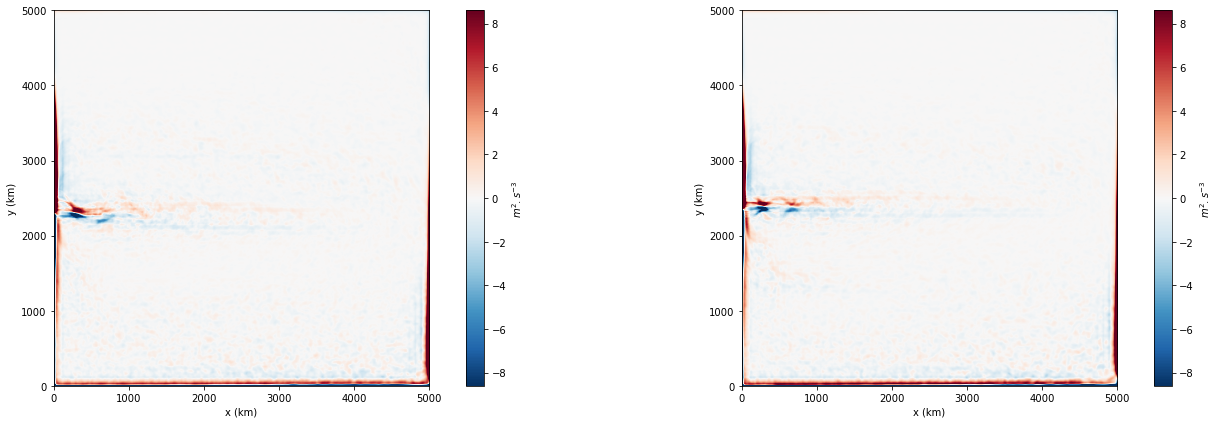

In [53]:
#sst

w_abs_me_i = integral_z(w_abs_me,dh_b,Delta,Ht_b)
w_rel_me_i = integral_z(w_rel_me,dh_b,Delta,Ht_b)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,6),tight_layout=True)

maxi = max(np.max(w_abs_me_i),np.abs(np.min(w_abs_me_i)))

col = ax1.imshow( w_abs_me_i, cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi/20, vmin = -maxi/20)
ax1.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(w_abs_me_i)
m.set_clim(-maxi/20, maxi/20)
plt.colorbar(m, ax= ax1 ).set_label(r'$m^2.s^{-3}$')

col = ax2.imshow( w_rel_me_i, cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi/20, vmin = -maxi/20)
ax2.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(w_rel_me_i)
m.set_clim(-maxi/20, maxi/20)
plt.colorbar(m, ax= ax2 ).set_label(r'$m^2.s^{-3}$')


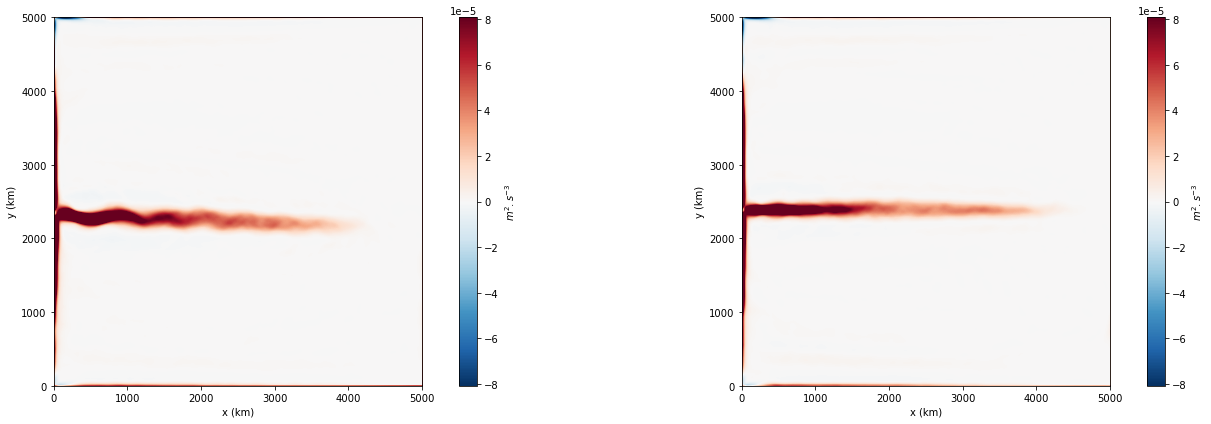

In [59]:
#map of barotropization
mke_abs = qg.comp_ke(p_abs_me, Delta)
mke_rel = qg.comp_ke(p_rel_me, Delta)

dke_dz_abs = div_z(mke_abs,dh,f0)
dke_dz_rel = div_z(mke_rel,dh,f0)

dke_dz_abs_i = integral_z(dke_dz_abs,dh , Delta, Ht_b)
dke_dz_rel_i = integral_z(dke_dz_rel,dh , Delta, Ht_b)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,6),tight_layout=True)

maxi = max(np.max(dke_dz_abs[0] ),np.abs(np.min(dke_dz_abs_i[0] )))

col = ax1.imshow( dke_dz_abs[0] , cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi/20, vmin = -maxi/20)
ax1.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(dke_dz_abs[0] )
m.set_clim(-maxi/20, maxi/20)
plt.colorbar(m, ax= ax1 ).set_label(r'$m^2.s^{-3}$')

col = ax2.imshow( dke_dz_rel[0], cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi/20, vmin = -maxi/20)
ax2.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(dke_dz_rel[0])
m.set_clim(-maxi/20, maxi/20)
plt.colorbar(m, ax= ax2 ).set_label(r'$m^2.s^{-3}$')

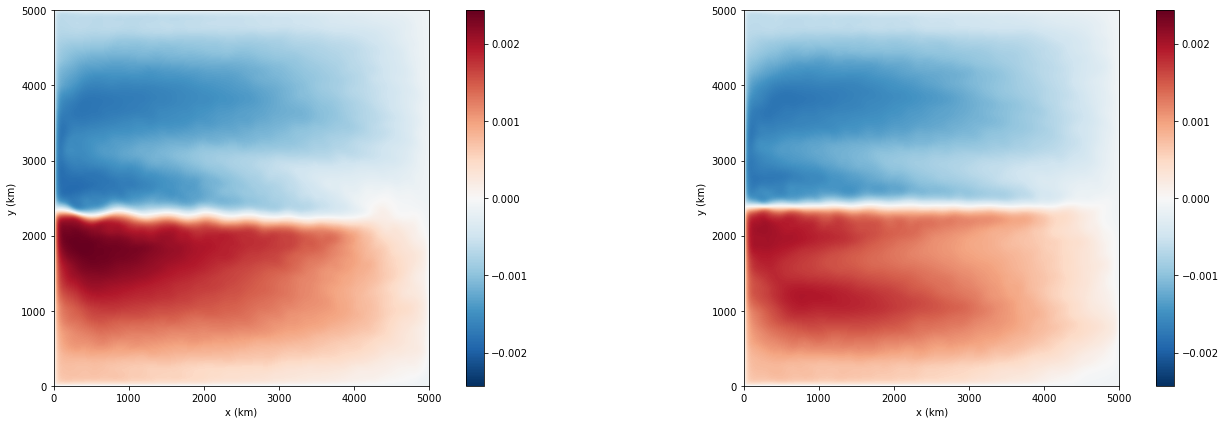

In [19]:
#b**2

b_me_abs_i = integral_z(b_abs_me, dh_b, Delta, Ht_b)
b_me_rel_i = integral_z(b_rel_me, dh_b, Delta, Ht_b)

maxi = max(np.max(b_me_abs_i),np.abs(np.min(b_me_abs_i)))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,6),tight_layout=True)


col = ax1.imshow( b_me_abs_i, cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi, vmin = -maxi)
ax1.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(b_me_abs_i)
m.set_clim(-maxi/3, maxi/3)
plt.colorbar(m, ax= ax1 )#.set_label(r'$m^2.s^{-3}$')

col = ax2.imshow( b_me_rel_i, cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi, vmin = -maxi)
ax2.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(b_me_rel_i)
m.set_clim(-maxi/3, maxi/3)
plt.colorbar(m, ax= ax2 )#.set_label(r'$m^2.s^{-3}$')


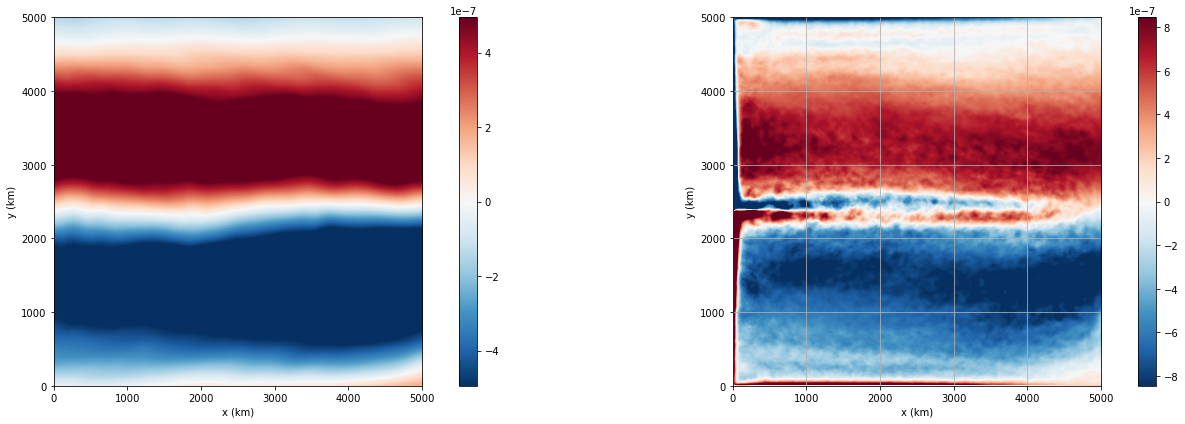

In [20]:
#w_ek
maxi = max(np.max(w_ek_me_abs),np.abs(np.min(w_ek_me_abs)))
maxi_rel = max(np.max(w_ek_me_rel),np.abs(np.min(w_ek_me_rel)))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,6),tight_layout=True)



col = ax1.imshow( w_ek_me_abs, cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi/2, vmin = -maxi/2)
ax1.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(w_ek_me_abs)
m.set_clim(-maxi/2, maxi/2)
plt.colorbar(m, ax= ax1 )#.set_label(r'$m^2.s^{-3}$')

col_rel = ax2.imshow( w_ek_me_rel, cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi_rel/10, vmin = -maxi_rel/10)
ax2.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2.grid()

m_rel = plt.cm.ScalarMappable(cmap='RdBu_r')
m_rel.set_array(w_ek_me_rel)
m_rel.set_clim(-maxi_rel/10, maxi_rel/10)
plt.colorbar(m_rel, ax= ax2 )#.set_label(r'$m^2.s^{-3}$')

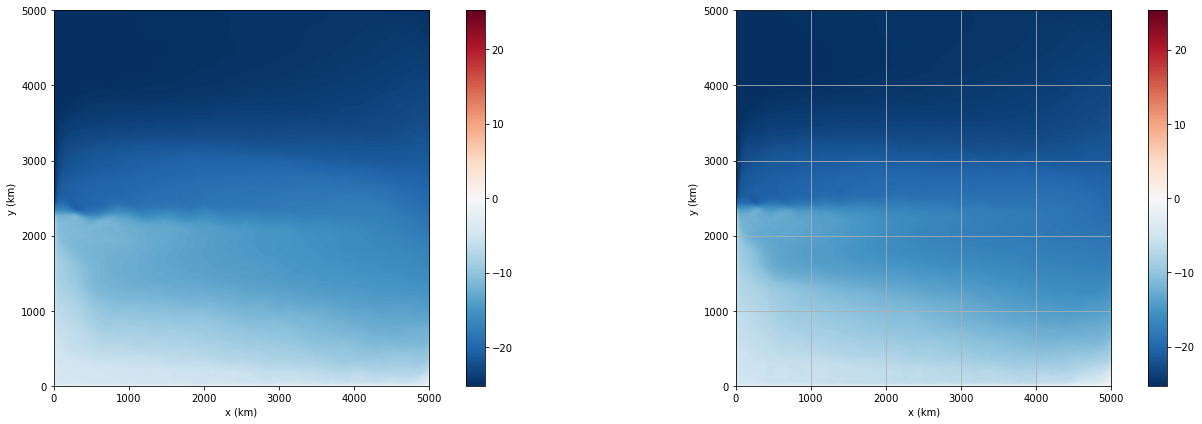

In [24]:
#for diab dans eq de b_t

maxi_abs = max(np.max((sst_me_abs-toc[0])),np.abs(np.min((sst_me_abs-toc[0]))))
maxi_rel = max(np.max((sst_me_rel-toc[0])),np.abs(np.min((sst_me_rel-toc[0]))))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,6),tight_layout=True)



col = ax1.imshow((sst_me_abs-toc[0]), cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi_abs, vmin = -maxi_abs)
ax1.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(sst_me_abs-toc[0])
m.set_clim(-maxi_abs, maxi_abs)
plt.colorbar(m, ax= ax1 )#.set_label(r'$m^2.s^{-3}$')

col_rel = ax2.imshow( sst_me_rel-toc[0], cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi_rel, vmin = -maxi_rel)
ax2.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2.grid()

m_rel = plt.cm.ScalarMappable(cmap='RdBu_r')
m_rel.set_array(sst_me_rel-toc[0])
m_rel.set_clim(-maxi_rel, maxi_rel)
plt.colorbar(m_rel, ax= ax2 )#.set_label(r'$m^2.s^{-3}$')

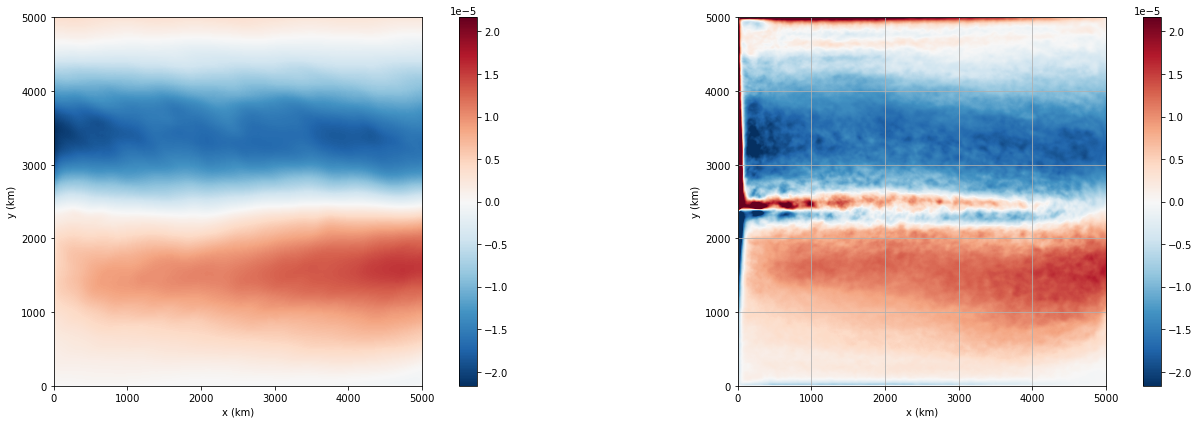

In [43]:
#for diab dans eq de b_t

ev_abs = (sst_me_abs-toc[0])*w_ek_me_abs
ev_rel = (sst_me_rel-toc[0])*w_ek_me_rel

maxi_abs = max(np.max(ev_abs), np.abs(np.min(ev_abs)))
maxi_rel = max(np.max(ev_rel), np.abs(np.min(ev_rel)))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,6),tight_layout=True)



col = ax1.imshow(ev_abs, cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi_abs, vmin = -maxi_abs)
ax1.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(ev_abs)
m.set_clim(-maxi_abs, maxi_abs)
plt.colorbar(m, ax= ax1 )#.set_label(r'$m^2.s^{-3}$')

col_rel = ax2.imshow( ev_rel, cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi_abs, vmin = -maxi_abs)
ax2.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2.grid()

m_rel = plt.cm.ScalarMappable(cmap='RdBu_r')
m_rel.set_array(ev_rel)
m_rel.set_clim(-maxi_abs, maxi_abs)
plt.colorbar(m_rel, ax= ax2 )#.set_label(r'$m^2.s^{-3}$')

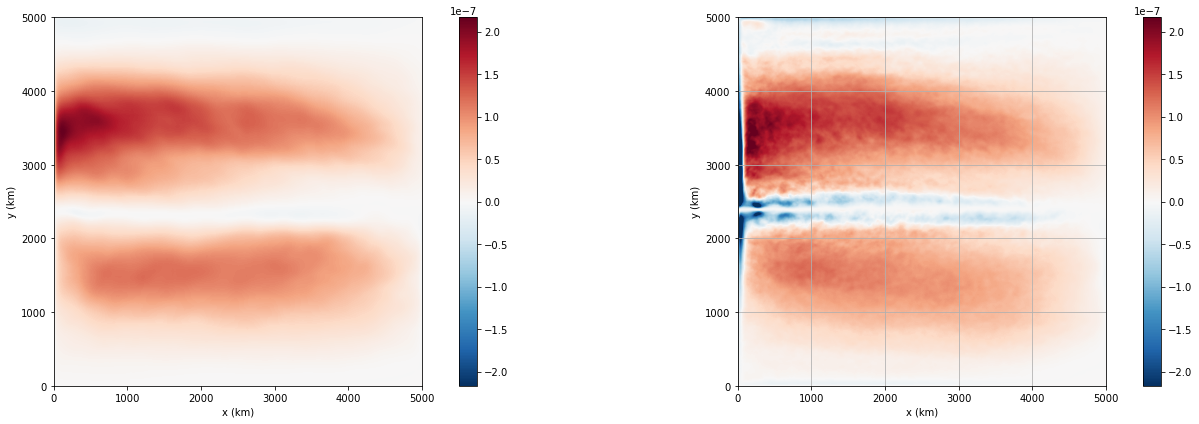

In [48]:
#for diab dans eq de b_t

ev_abs = (sst_me_abs-toc[0])*w_ek_me_abs*b_abs_me[0,:-1,:-1]
ev_rel = (sst_me_rel-toc[0])*w_ek_me_rel*b_rel_me[0,:-1,:-1]

maxi_abs = max(np.max(ev_abs), np.abs(np.min(ev_abs)))
maxi_rel = max(np.max(ev_rel), np.abs(np.min(ev_rel)))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,6),tight_layout=True)



col = ax1.imshow(ev_abs, cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi_abs, vmin = -maxi_abs)
ax1.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(ev_abs)
m.set_clim(-maxi_abs, maxi_abs)
plt.colorbar(m, ax= ax1 )#.set_label(r'$m^2.s^{-3}$')

col_rel = ax2.imshow( ev_rel, cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi_abs, vmin = -maxi_abs)
ax2.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2.grid()

m_rel = plt.cm.ScalarMappable(cmap='RdBu_r')
m_rel.set_array(ev_rel)
m_rel.set_clim(-maxi_abs, maxi_abs)
plt.colorbar(m_rel, ax= ax2 )#.set_label(r'$m^2.s^{-3}$')

Text(0, 0.5, 'z ')

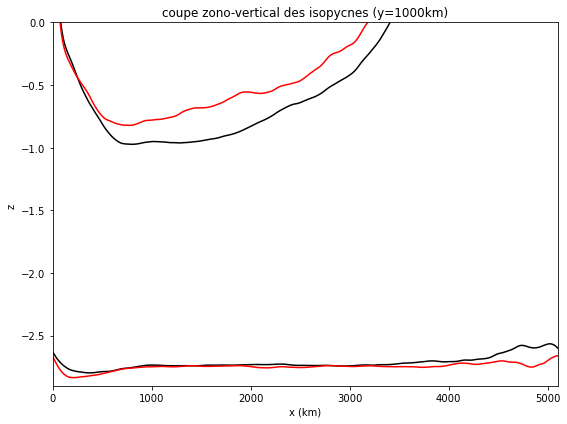

In [17]:
#isopycnes en x env 1000

z= np.array([0,2.9])

rho_y = 1000*(1-b_me[:,100,:]/9.81) 

rho_y_rel = 1000*(1-b_me_rel[:,100,:]/9.81) 




#maxi = max(np.max(e_diab_i),np.abs(np.min(e_diab_i)))



fig, ax1 = plt.subplots(1, 1, figsize = (8,6),tight_layout=True)

ax1.contour(xp,-z, rho_y_rel, levels = 1, colors = 'black')
ax1.contour(xp,-z, rho_y, levels = 1, colors = 'red')
#ax1.contour(xp , -zp, rho_y_nord, levels = 1, colors = 'blue')
#ax1.set_aspect('equal')
ax1.set_title('coupe zono-vertical des isopycnes (y=1000km)')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('z ')



In [18]:
print(rho_y_rel[:,511])
print(rho_y_rel[:,0])

[ 999.98596204 1000.00159377]
[ 999.88341649 1000.01189592]


Text(0, 0.5, 'z ')

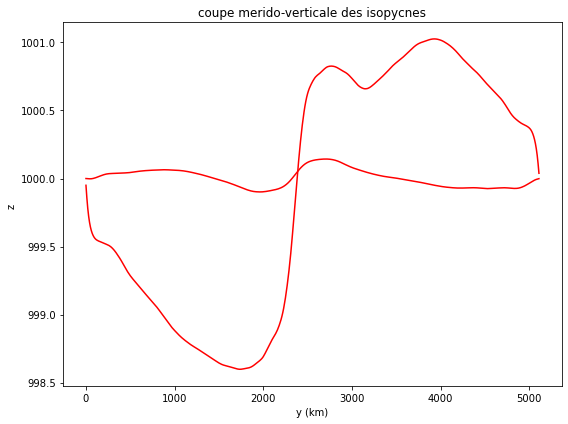

In [19]:
#isopycnes en x env 1000

rho_x = 1000*(1-b_me[:,:,100]/9.81) 

rho_x_rel = 1000*(1-b_me_rel[:,:,100]/9.81) 




#maxi = max(np.max(e_diab_i),np.abs(np.min(e_diab_i)))



fig, ax1 = plt.subplots(1, 1, figsize = (8,6),tight_layout=True)


ax1.plot(xp , rho_x[0], color = 'red')
ax1.plot(xp , rho_x[1], color = 'red')
#ax1.plot(xp , rho_x_rel, color = 'black')
#ax1.contour(xp , -zp, rho_y_nord, levels = 1, colors = 'blue')
#ax1.set_aspect('equal')
ax1.set_title('coupe merido-verticale des isopycnes')
ax1.set_xlabel('y (km)')
ax1.set_ylabel('z ')
#ax1.legend(['absolute wind',
#            'relative wind'])



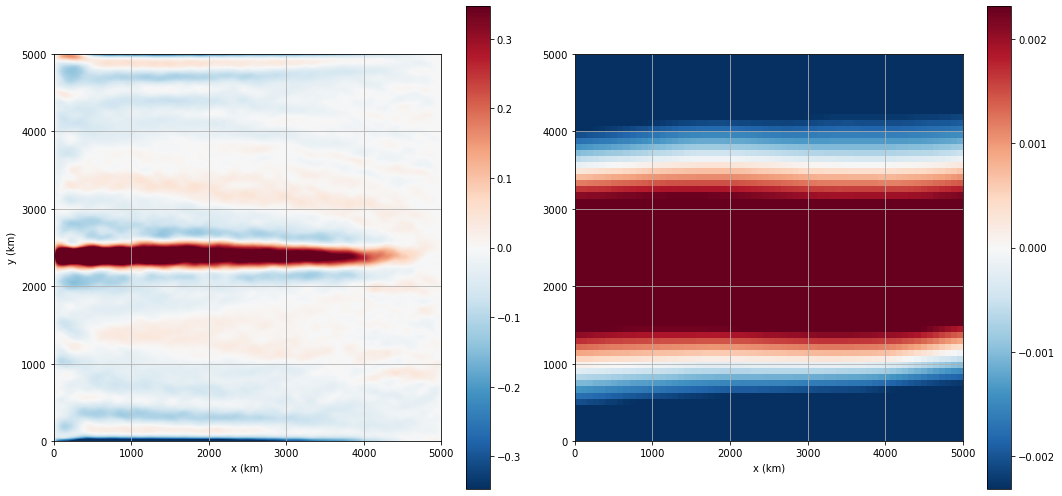

In [20]:
#dy_u_me_rel = div_y(u_me_rel, Delta)

maxi = max(np.max(u_me_rel),np.abs(np.min(u_me_rel)))
maxi_rel = max(np.max(u_at_me_rel[0,17:81,161:225]),np.abs(np.min(u_at_me_rel[0,17:81,161:225])))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15,7),tight_layout=True)



col = ax1.imshow( u_me_rel[0], cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi/4, vmin = -maxi/4)
ax1.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')
ax1.grid()

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(u_me_rel[0])
m.set_clim(-maxi/4, maxi/4)
plt.colorbar(m, ax= ax1 )#.set_label(r'$m^2.s^{-3}$')

col_rel = ax2.imshow( u_at_me_rel[0,17:81,161:225], cmap='RdBu_r', extent = [0,5000,0,5000], origin='lower', vmax = maxi_rel/2, vmin = -maxi_rel/2)
ax2.set_aspect('equal')
#ax1.set_title(r'Wind forcing term in $\overline{\overline{KE}}_t$')
ax2.set_xlabel('x (km)')
#ax2.set_ylabel('y (km)')
ax2.grid()

m_rel = plt.cm.ScalarMappable(cmap='RdBu_r')
m_rel.set_array(u_at_me_rel[0,17:81,161:225])
m_rel.set_clim(-maxi_rel/2, maxi_rel/2)
plt.colorbar(m_rel, ax= ax2 )#.set_label(r'$m^2.s^{-3}$')